# **Association Rule Learning using the Dataset Online Retail II**

## **Goal: Suggesting products to users at the basket stage**

## **Variables**
#### InvoiceNo: Invoice Number (If this code starts with C, it means that the transaction has been cancelled)
#### StockCode: Product code (unique for each product)
#### Description: Product name
#### Quantity: Number of products (How many of the products on the invoices were sold)
#### InvoiceDate: Invoice date
#### UnitPrice: Invoice price ( Sterling )
#### CustomerID: Unique customer number
#### Country: Country name

# **1. Data Preparation**

In [1]:
# importing the libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from mlxtend.frequent_patterns import apriori, association_rules
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.expand_frame_repr', False)   # ensures that the output is on a single line

In [2]:
df = pd.read_excel('/kaggle/input/uci-online-retail-ii-data-set/online_retail_II.xlsx', sheet_name='Year 2010-2011')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


In [3]:
df.columns = [col.lower() for col in df.columns]

In [4]:
df = df.copy()
df.head()

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.00,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.00,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.00,United Kingdom


In [5]:
# get the descriptive_statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,541910.00,9.55,218.08,-80995.00,1.00,3.00,10.00,80995.00
price,541910.00,4.61,96.76,-11062.06,1.25,2.08,4.13,38970.00
customer id,406830.00,15287.68,1713.60,12346.00,13953.00,15152.00,16791.00,18287.00


* The variables quantity and price have negative values because of the C expressions in the variable invoice.
* C means 'Cancel' of the order.
* They should remove from the dataset.

In [6]:
# get the missing data
df.isnull().sum().sort_values(ascending=False)

customer id    135080
description      1454
invoice             0
stockcode           0
quantity            0
invoicedate         0
price               0
country             0
dtype: int64

* Customer id and description have missing data. 
* We can remove them since there are many data in the dataset.

In [7]:
# to solve the above problems, define the following function named 'retail_data_prep'.
def retail_data_prep(dataframe):
    dataframe.dropna(inplace=True)  # to drop the missing data
    dataframe[dataframe['invoice'].str.contains('C', na=False)] # to remove the data that include 'C' expressions
    dataframe = dataframe[dataframe['price'] > 0] # to remove the negative price data
    dataframe = dataframe[dataframe['quantity'] > 0] # to remove the negative quantity data
    
    return dataframe

In [8]:
df = retail_data_prep(df)

In [9]:
df.isnull().sum()

invoice        0
stockcode      0
description    0
quantity       0
invoicedate    0
price          0
customer id    0
country        0
dtype: int64

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,397885.00,12.99,179.33,1.00,2.00,6.00,12.00,80995.00
price,397885.00,3.12,22.10,0.00,1.25,1.95,3.75,8142.75
customer id,397885.00,15294.42,1713.14,12346.00,13969.00,15159.00,16795.00,18287.00


* Now there is no missng data and negative values
* However, there is also another problem with outliers. 
* We can show them using seaborn library as follows:

In [11]:
def check_outliers(dataframe, variable):
    sns.boxplot(x=dataframe[variable])
    plt.show(block=True)

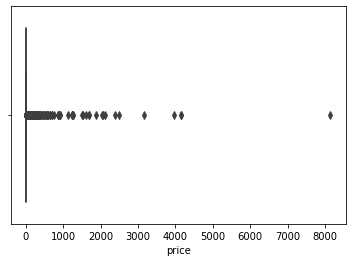

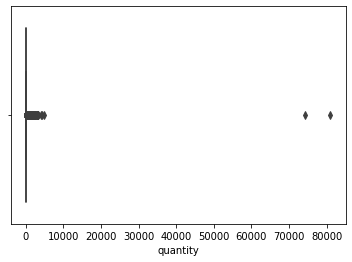

In [12]:
columns = ['price', 'quantity']
for col in columns:
    check_outliers(df, col)

* Therefore, we should remove some outliers from the dataset.
* First, we should determine the outlier thresholds,
* Then we should replace the outliers with thresholds as follows:

In [13]:
def outlier_thresholds(dataframe, variable, q1=0.01, q3=0.99):
    quantile1 = dataframe[variable].quantile(q1)
    quantile3 = dataframe[variable].quantile(q3)
    iqr = quantile3 - quantile1
    low_limit = quantile1 - 1.5 * iqr
    up_limit = quantile3 + 1.5 * iqr
    return low_limit, up_limit

In [14]:
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[dataframe[variable] < low_limit, variable] = low_limit
    dataframe.loc[dataframe[variable] > up_limit, variable] = up_limit

In [15]:
for col in columns:
    replace_with_thresholds(df, col)

* Now we changed the outliers with the thresholds. 
* By calling the check_aoutlier function,we can check whether the process of ok or not.
* Or we can analyze the descriptive statistics as follows:

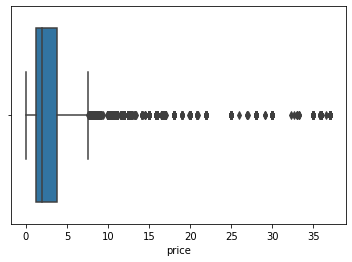

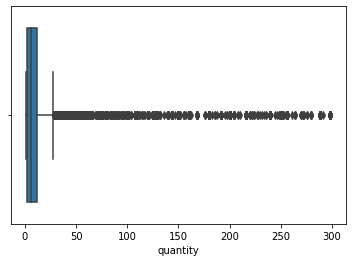

In [16]:
for col in columns:
    check_outliers(df, col)

In [17]:
# check the descriptive statistics again
df.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,397885.00,11.83,25.52,1.00,2.00,6.00,12.00,298.50
price,397885.00,2.89,3.23,0.00,1.25,1.95,3.75,37.06
customer id,397885.00,15294.42,1713.14,12346.00,13969.00,15159.00,16795.00,18287.00


Thus, the outliers in max were significantly removed.

# **2. Preparing the Association Rule Learning Data Structures**

### **Let's move forward by reducing the dataset to a specific country, for instance United Kingdom**
### **So here the association rules of UK customers are derived.**

In [18]:
df_fr = df[df['country'] == 'France']
df_fr.head()

,invoice,stockcode,description,quantity,invoicedate,price,customer id,country
26,536370,22728,ALARM CLOCK BAKELIKE PINK,24.00,2010-12-01 08:45:00,3.75,12583.00,France
27,536370,22727,ALARM CLOCK BAKELIKE RED,24.00,2010-12-01 08:45:00,3.75,12583.00,France
28,536370,22726,ALARM CLOCK BAKELIKE GREEN,12.00,2010-12-01 08:45:00,3.75,12583.00,France
29,536370,21724,PANDA AND BUNNIES STICKER SHEET,12.00,2010-12-01 08:45:00,0.85,12583.00,France
30,536370,21883,STARS GIFT TAPE,24.00,2010-12-01 08:45:00,0.65,12583.00,France


In [19]:
df_fr.shape   

(8342, 8)

### Let's create a matrix named 'invoice_product' and define a function

In [20]:
def create_invoice_product_df(dataframe, id=False):
    if id:
        return dataframe.groupby(['invoice', 'stockcode'])['quantity'].sum().unstack().fillna(0).applymap(lambda x: 1 if x > 0 else 0)
    else:
        return dataframe.groupby(['invoice', 'description'])['quantity'].sum().unstack().fillna(0).applymap(lambda x: 1 if x > 0 else 0)

fr_inv_pro_df = create_invoice_product_df(df_fr, id=True)
fr_inv_pro_df.head()

stockcode,10002,10120,10125,10135,11001,15036,15039,16012,16048,16218,16219,16225,16236,16237,16238,17174,20615,20617,20658,20665,20668,20674,20675,20676,20677,20679,20681,20682,20684,20685,20686,20702,20704,20711,20712,20713,20717,20718,20719,20723,20724,20725,20726,20727,20728,20749,20750,20751,20767,20777,20819,20832,20866,20914,20961,20963,20966,20967,20971,20972,20973,20974,20975,20977,20978,20979,20981,20983,20984,20992,20996,21012,21026,21027,21030,21034,21035,21039,21042,21054,21055,21056,21058,21059,21061,21062,21063,21064,21065,21068,21069,21070,21078,21080,21084,21086,21087,21088,21090,21094,21095,21096,21098,21108,21110,21111,21114,21116,21121,21122,21123,21124,21125,21126,21135,21136,21137,21154,21155,21156,21161,21162,21163,21164,21165,21166,21174,21175,21181,21188,21194,21195,21196,21197,21198,21199,21200,21201,21202,21204,21205,21206,21207,21208,21209,21210,21212,21213,21216,21217,21218,21219,21221,21224,21231,21232,21238,21239,21240,21242,21243,21244,21245,21246,21248,21249,21251,21257,21258,21259,21262,21284,21286,21294,21306,21326,21328,21329,21340,21351,21354,21355,21356,21358,21361,21365,21369,21371,21372,21374,21375,21377,21380,21381,21383,21385,21394,21395,21398,21399,21402,21403,21407,21408,21411,21424,21425,21426,21427,21428,21429,21430,21439,21442,21452,21463,21466,21467,21469,21470,21471,21472,21479,21481,21484,21485,21494,21495,21497,21498,21499,21500,21506,21507,21508,21509,21519,21523,21524,21527,21528,21531,21533,21535,21537,21539,21544,21555,21556,21557,21558,21559,21561,21563,21564,21576,21577,21578,21579,21581,21584,21591,21621,21622,21623,21624,21643,21648,21650,21658,21668,21669,21671,21672,21673,21675,21677,21678,21679,21680,21693,21696,21698,21700,21703,21704,21706,21707,21708,21709,21710,21711,21715,21716,21719,21721,21723,21724,21725,21731,21733,21739,21746,21747,21749,21754,21755,21756,21770,21774,21786,21787,21790,21791,21812,21813,21818,21819,21821,21828,21829,21832,21833,21843,21844,21845,21864,21865,21866,21871,21872,21875,21877,21880,21881,21882,21883,21884,21888,21889,21890,21891,21892,21894,21900,21901,21905,21906,21907,21908,21912,21913,21914,21915,21916,21917,21918,21922,21926,21928,21929,21930,21931,21932,21933,21934,21935,21936,21937,21943,21946,21947,21948,21949,21955,21967,21972,21974,21975,21976,21977,21980,21981,21982,21983,21985,21986,21987,21988,21989,21990,22023,22024,22025,22026,22027,22028,22029,22032,22035,22037,22041,22043,22044,22045,22046,22051,22052,22059,22063,22064,22065,22068,22070,22071,22072,22073,22076,22077,22078,22079,22080,22081,22082,22083,22084,22085,22086,22087,22088,22089,22090,22091,22093,22094,22099,22109,22110,22111,22112,22113,22114,22115,22116,22118,22120,22121,22124,22129,22130,22131,22132,22133,22134,22136,22138,22139,22141,22142,22144,22149,22150,22151,22153,22170,22174,22175,22176,22178,22179,22180,22181,22189,22191,22192,22193,22195,22197,22198,22199,22200,22203,22204,22207,22208,22209,22210,22211,22215,22219,22221,22222,22223,22224,22228,22231,22232,22236,22242,22243,22244,22254,22255,22262,22264,22269,22271,22272,22273,22274,22282,22285,22294,22295,22299,22300,22301,22302,22303,22305,22306,22309,22311,22312,22313,22314,22315,22318,22319,22320,22321,22322,22324,22325,22326,22327,22328,22329,22331,22332,22333,22334,22339,22340,22341,22343,22344,22346,22348,22349,22350,22352,22354,22355,22356,22357,22358,22361,22362,22365,22366,22367,22371,22372,22374,22375,22376,22377,22378,22379,22380,22381,22382,22383,22384,22385,22386,22389,22390,22393,22394,22396,22398,22399,22400,22402,22403,22406,22408,22411,22412,22413,22414,22416,22417,22418,22419,22422,22423,22425,22427,22431,22432,22433,22434,22435,22436,22437,22438,22439,22440,22443,22444,22445,22449,22451,22452,22453,22454,22456,22457,22459,22466,22467,22468,22469,22471,22472,22474,22475,22480,22482,22483,22485,22489,22491,22492,22493,22495,22498,22499,22500,22501,22502,22504,22505,22507,22508,22514,22515,22516,22517,22518,22519,22520,22521,22522,22523,22524,22525,22526,22529,22530,22531,22532,

In [21]:
fr_inv_pro_df.shape

(389, 1522)

* Now we created the pivot table usign stockcode. 
* If id = False, we could create the pivot table accroding to the description
* Let's write a function named 'check_id' to check which product the id values are.

In [22]:
def check_id(dataframe, stock_code):
    product_name = dataframe[dataframe['stockcode'] == stock_code][['description']].values[0].tolist()
    print(product_name)

In [23]:
check_id(df_fr, 11001) # ['ASSTD DESIGN RACING CAR PEN']

['ASSTD DESIGN RACING CAR PEN']


In [24]:
check_id(df_fr, 16218) # ['CARTOON  PENCIL SHARPENERS']

['CARTOON  PENCIL SHARPENERS']


# **3. Association Rule Analysis**

* After creating the pivot table, now we can make the association rule analysis using apriori and association_rules methods.
* Finding the support values, i.e. probabilities, of all possible visual associations with the apriori method

In [25]:
frequnt_items = apriori(fr_inv_pro_df, min_support=0.01, use_colnames=True)
frequnt_items.sort_values('support', ascending=False)

/opt/conda/lib/python3.7/site-packages/mlxtend/frequent_patterns/fpcommon.py:115: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,


,support,itemsets
538,0.77,(POST)
387,0.19,(23084)
107,0.18,(21731)
243,0.17,(22554)
245,0.17,(22556)
...,...,...
18793,0.01,"(22729, 21086, 22326, 22551)"
18787,0.01,"(23256, 21086, 22492, 22326)"
18786,0.01,"(22728, 21086, 22492, 22326)"
18785,0.01,"(21086, 22492, 22326, 22727)"


* Thus, product pairs and their corresponding support values are obtained.
* Association rules are deduced using this obtained data as follows:

In [26]:
rules = association_rules(frequnt_items, metric='support', min_threshold=0.01)

* Reducing the rules according to some thresholds of support, confidence and lift values

In [27]:
reduced_rules = rules[(rules['support'] > 0.05) & (rules['confidence'] > 0.01) & (rules['lift'] > 5)]
reduced_rules   # [84 rows x 9 columns]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1606,(21080),(21086),0.13,0.14,0.10,0.77,5.54,0.08,3.73
1607,(21086),(21080),0.14,0.13,0.10,0.74,5.54,0.08,3.34
1608,(21080),(21094),0.13,0.13,0.10,0.77,5.98,0.09,3.78
1609,(21094),(21080),0.13,0.13,0.10,0.80,5.98,0.09,4.33
1776,(21086),(21094),0.14,0.13,0.12,0.89,6.92,0.11,7.84
...,...,...,...,...,...,...,...,...,...
213940,"(POST, 22727)","(22728, 22726)",0.09,0.07,0.06,0.66,8.81,0.05,2.70
213941,"(22726, 22727)","(22728, POST)",0.08,0.09,0.06,0.74,8.02,0.05,3.52
213942,(22728),"(POST, 22726, 22727)",0.10,0.07,0.06,0.57,7.71,0.05,2.18
213944,(22726),"(22728, POST, 22727)",0.10,0.07,0.06,0.61,8.72,0.05,2.36


* Now check the id of some products

In [28]:
check_id(df_fr, 21080)  # ['SET/20 RED RETROSPOT PAPER NAPKINS ']

['SET/20 RED RETROSPOT PAPER NAPKINS ']


In [29]:
check_id(df_fr, 22727)  # ['ALARM CLOCK BAKELIKE RED ']

['ALARM CLOCK BAKELIKE RED ']


# **4. Functionalization of the above processes**

In [30]:
def create_rules(dataframe, id=True, country='France'):
    dataframe = dataframe[dataframe['country'] == country]
    dataframe = create_invoice_product_df(dataframe, id)
    frequnt_items = apriori(dataframe, min_support=0.01, use_colnames=True)
    rules = association_rules(frequnt_items, metric='support', min_threshold=0.01)

    return rules

rules = create_rules(df_fr)
rules.sort_values('lift', ascending=False)

/opt/conda/lib/python3.7/site-packages/mlxtend/frequent_patterns/fpcommon.py:115: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  DeprecationWarning,


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1082358,"(22659, 23206, 22726, 22727)","(21558, 23254, 22326, 23199)",0.01,0.01,0.01,1.00,97.25,0.01,inf
1160023,"(22727, 22728, 22352, 23254, 23199)","(22326, 21558, 22726, 20750)",0.01,0.01,0.01,1.00,97.25,0.01,inf
1160025,"(22727, 22728, 21558, 23254, 22326)","(22352, 23199, 22726, 20750)",0.01,0.01,0.01,1.00,97.25,0.01,inf
1160026,"(22727, 22728, 23254, 22326, 23199)","(22352, 21558, 22726, 20750)",0.01,0.01,0.01,1.00,97.25,0.01,inf
1160027,"(22727, 22728, 21558, 22326, 23199)","(22352, 23254, 22726, 20750)",0.01,0.01,0.01,1.00,97.25,0.01,inf
...,...,...,...,...,...,...,...,...,...
2744,(POST),(21535),0.77,0.03,0.01,0.01,0.47,-0.01,0.98
25539,(21080),"(POST, 23084)",0.13,0.17,0.01,0.08,0.46,-0.01,0.90
25538,"(POST, 23084)",(21080),0.17,0.13,0.01,0.06,0.46,-0.01,0.92
1742,(21080),(23084),0.13,0.19,0.01,0.08,0.41,-0.01,0.88


# **5. Product Recommendation Application**

In [31]:
def arl_recommender(rules_df, product_id, recommend_count=1):
    sorted_rules = rules_df.sort_values('lift', ascending=False)
    recommendation_list = []
    for i, product in enumerate(sorted_rules['antecedents']):
        for j in list(product):
            if j == product_id:
                recommendation_list.append(list(sorted_rules.iloc[i]['consequents'])[0])
    return recommendation_list[0: recommend_count]

In [32]:
product_1 = arl_recommender(rules, 21791, 1)
check_id(df_fr, product_1[0])

['POSTAGE']


In [33]:
product_2 = arl_recommender(rules, 21791, 2)
for i in product_2:
    check_id(df_fr, i)

['POSTAGE']
['POSTAGE']


In [34]:
product_3 = arl_recommender(rules, 21558, 3)    # [22352, 22352, 22728]
for i in product_3:
    check_id(df_fr, i)

['LUNCH BOX WITH CUTLERY RETROSPOT ']
['LUNCH BOX WITH CUTLERY RETROSPOT ']
['ALARM CLOCK BAKELIKE PINK']


# **6. Consequent**

### **Consequently, which products should be recommended for a product were handled programmatically.**